## Load in modules and functions

In [204]:
import cv2
import pandas as pd # for working with dataframes
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for images
from scipy.interpolate import interp1d # for interpolating points
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis
import seaborn as sns # for plotting in seaborn
import math # for math
from scipy.stats import zscore # for zscore

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def detect_pointy_tips(contour, window):
    """
    define a function to calculate how pointy each point in a contour is
    inputs: the contour and the window to define neighbors
    outputs: the angles of each contour point
    """
    pointy_tips = []
    for i in range(len(contour)):
        # Get the current point and its neighbors, defined by window
        p2 = contour[i]
        p3 = contour[(i + window) % len(contour)]
        p1 = contour[(i - window) % len(contour)]

        # Calculate the angle between the two vectors formed by the neighbors
        angle = angle_between(p1, p2, p3)

        # save current angle
        pointy_tips.append(angle)

    return pointy_tips

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

def foo(a, start, stop): 
    # fn to convert start stop to a wrapped range
    if stop<=start:
        stop += len(a)
    return np.arange(start, stop)%len(a)

def average_contour_color(image, contour):
    """
    Calculates the average RGB color within a contour.

    Args:
        image (numpy.ndarray): The input image.
        contour (numpy.ndarray): The contour.

    Returns:
        tuple: The average BGR color (Blue, Green, Red).
    """
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    
    masked_image = cv2.bitwise_and(image, image, mask=mask)
  
    b, g, r = cv2.mean(masked_image, mask=mask)[:3]
    return (r, g, b)

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

## Place landmarks

In [205]:
######################
### SET PARAMETERS ###
######################

data_dir = "./images/" # set data directory
land_dir = "./landmarks/" # set directory with landmarks
threshx = 50 # set threshold for segmentation
min_area = 500 # minimum selection area
max_area = 3000 # maximum selection area
res = 203 # how many points to interpolate (ultimately res-1 points)
win = 60 # window size for detecting angles

kernel_list = [] # a list storing arrays of reoriented kernel data
name_list = [] # a list storing line names

#####################################################
#####################################################
#####################################################

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

if '.DS_Store' in file_names:
    file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

line_names = [] # to store names of the lines
for i in range(len(file_names)): # for each file name
    line_names.append(file_names[i][:-4]) # store the line name

for z in range(len(line_names)): # for each line

    # specify the line name
    name = line_names[z] 
    print(name)

    # load image and find contours
    image = cv2.imread(data_dir + name + '.jpg')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, threshx, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #########################################
    ### FILTER OUT CONTOURS BASED ON AREA ###
    #########################################

    conts = [] # store contours meeting filter area critera
    all_areas = [] # store all areas > 3 vertices
    filtered_areas = [] # store only areas meeting filter
    
    for i in range(len(contours)):
        if np.shape(contours[i])[0] > 3:
            con = np.reshape(contours[i], (np.shape(contours[i])[0], 2))
            all_areas.append(poly_area(con[:,0], con[:,1]))
            
        else:
            continue
    
        if (poly_area(con[:,0], con[:,1])<max_area) & (poly_area(con[:,0], con[:,1])>min_area):
            conts.append(con)
            filtered_areas.append(poly_area(con[:,0], con[:,1]))

    ####################################################
    ### INTERPOLATE AND MEASURE ANGLES AND DISTANCES ###
    ####################################################
    #-  Set resolution of interpolation
    #-  Add the first point to the last position of the contour, to close the contour
    #-  Interpolate
    #-  Remove last interpolated point (due to overlap)
    #-  For each point, calculate angle as defined by window, convert to z score
    #-  For each point, calcualte Euclidean distance to centroid, convert to z score
    #-  Save results as 4 dimensional array: x coordinate, y coordinate, angle z score, distance z score

    z_arr = np.zeros( (len(conts), res-1, 4))
    
    for i in range(len(conts)): # for each contour
    
        # select current contour
        curr_cont = conts[i]
        
        # close the contour
        closed_arr = np.zeros((len(curr_cont)+1,2))
        closed_arr[:-1] = curr_cont
        closed_arr[-1] = curr_cont[0]
        
        # calculate interpolated contour
        interp = np.column_stack(interpolation(closed_arr[:,0], closed_arr[:,1], res)) 
        
        # remove last point of interpolation
        interp = interp[:-1]
        
        # find angles for each contour point
        angs = detect_pointy_tips(interp, win)
        ang_z = zscore(angs)
    
        # find distances to centroid
        cent = np.mean(interp, axis=0)
    
        dists = []
        for j in range(len(interp)):
            dists.append(euclid_dist(cent[0],cent[1], interp[j][0], interp[j][1]))
        dist_z = zscore(dists)
            
        # store contour, angles, dists
        z_arr[i] = np.column_stack((interp, ang_z, dist_z))


    ################################
    ### ORIENT DATA TO LANDMARKS ###
    ################################
    #- for each contour, find the closest landmark
    #- reindex data so that the tip is index = 0

    # load in landmark data
    landmarks = np.loadtxt(land_dir + name + ".txt")
    
    oriented_arr = np.zeros(np.shape(z_arr)) # array to store oriented data
    
    for i in range(len(z_arr)):
    
        # retrieve the pseudo_landmarks
        pseudos = z_arr[i,:,0:2]
        
        l_inds = [] # store landmark indices
        p_inds = [] # store pseudo-landmark indices
        eds = [] # store euclidean distances
        
        for l in range(len(landmarks)): # for each landmark
            for p in range(len(pseudos)): # for each pseudo-landmark
        
                # calculate eulidean distance
                eds.append(euclid_dist(landmarks[l,0],landmarks[l,1],pseudos[p,0],pseudos[p,1]))
                # store landmark and pseudo-landmark indices
                l_inds.append(l)
                p_inds.append(p)
        
        min_ind = np.argmin(np.array(eds)) # find minimum index
        pseudo_ind = p_inds[min_ind] # find the pseudo_landmark index
    
        # re-index contour coords and angs and dists
        oriented_arr[i,:,:] = np.concatenate((z_arr[i,pseudo_ind:,:],z_arr[i,:pseudo_ind,:]))


    kernel_list.append(oriented_arr) # store oriented data

    names = [name] # store name data
    names = names*len(oriented_arr)
    name_list.append(names)

kernel_arr = np.concatenate(kernel_list) # create an array of kernel data
name_arr = np.concatenate(name_list) # create an array of kernel line name data

geno1
geno2


## Color

Define indices of polygons to retrieve color

In [245]:
intervals = 50 # desired intervals to sample color
tip_ind = (res-1)/2 # get the index of the tip

side1_inds = np.round(np.linspace(0,tip_ind,intervals+1)) # get side intervals
side2_inds = np.round(np.linspace(tip_ind,res-2,intervals+1))

# calculate boundaries of polygons
index_list = [] # store indices defining polygons
for i in range(intervals): # for the number of intervals
    pt1 = side1_inds[i] # define the 4 point
    pt2 = side1_inds[i+1]
    pt3 = side2_inds[intervals-i-1]
    pt4 = side2_inds[intervals-i]
    index_list.append([pt1,pt2,pt3,pt4]) # append to index list

# calculate indices of polygons
poly_inds = [] # store indices of polygons
for i in range(len(index_list)): # for each polygon
    # calculate all points for each polygon
    side1 = np.arange(index_list[i][0],index_list[i][1]+1,1)
    side2 = np.arange(index_list[i][2],index_list[i][3]+1,1)
    poly_inds.append(np.concatenate((side1,side2)).astype(int))

In [246]:
color_arr = np.zeros( (len(kernel_arr),intervals) , dtype='U10')

for i in range(len(kernel_arr)): # for each kernel

    coords = kernel_arr[i,:,0:2]
    name = name_arr[i]
    
    image = cv2.imread(data_dir + name + '.jpg')
    
    for j in range(intervals): # for each of the polygons
    
        poly_coords = coords[poly_inds[j],:] # get the polygon coordinates
        rgb_vals = average_contour_color(image, poly_coords.astype(int)) # get average rgb value
        int_rgb = tuple([int(x) for x in rgb_vals]) # convert rgb values into integer
        color_arr[i,j] = rgb_to_hex(int_rgb) # convert to hex color and store


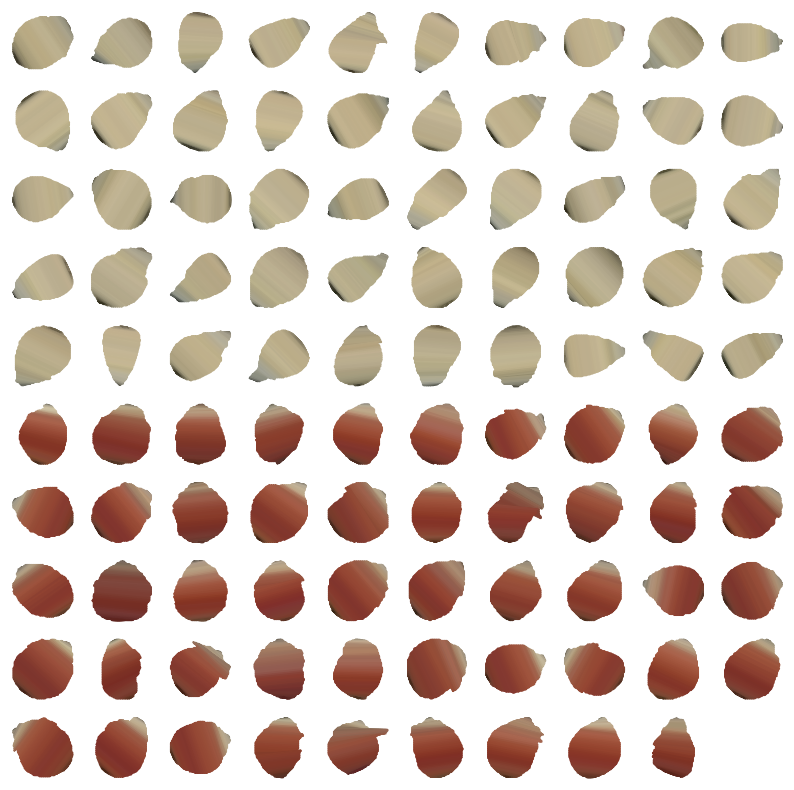

In [247]:
plt.figure(figsize=(10,10))

for i in range(len(kernel_arr)):

    plt.subplot(10,10,i+1)

    for j in range(len(poly_inds)):
        plt.fill(kernel_arr[i,poly_inds[j],0],kernel_arr[i,poly_inds[j],1],c=color_arr[i,j])
        plt.gca().set_aspect("equal")
        plt.axis("off")
    

## Procrustes

In [15]:
landmark_num = res-1 # select number of landmarks
dim_num = 4 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(kernel_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(kernel_arr)) 

for i in range(len(kernel_arr)):
    s1, s2, distance = procrustes(mean_shape, kernel_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array

Text(0.5, 1.0, 'overall kernel')

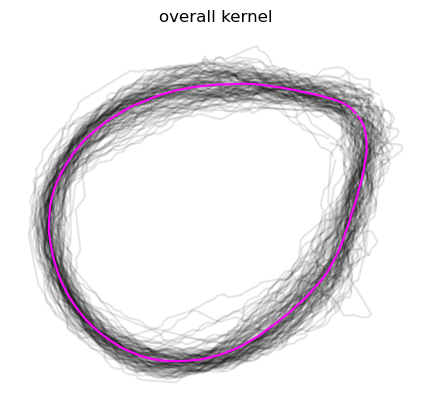

In [16]:
for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.1)

plt.plot(np.mean(proc_arr, axis=0)[:,0], np.mean(proc_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("overall kernel")

## Load in image
Note the setting of the grayscale threshold level. It had to be lowered for the darker kernel example. We should probably investigate color or more sophisticated thresholding

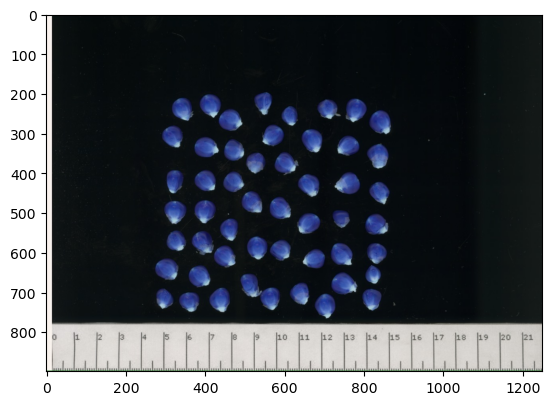

In [92]:
# Specify the file name
name = "geno2"

# Set threshold
thresh = 50

# Load image and find contours
image = cv2.imread(name + '.jpeg')
plt.imshow(image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Visualize the thresholding.

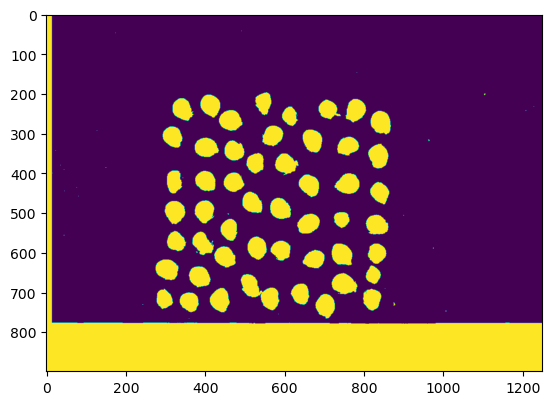

In [93]:
plt.imshow(thresh)

## Filter thresholded contours by area
Filter our contours below/above certain area, or below 3 vertices

In [94]:
min_area = 500
max_area = 3000

conts = []
all_areas = []
filtered_areas = [] 

for i in range(len(contours)):
    if np.shape(contours[i])[0] > 3:
        con = np.reshape(contours[i], (np.shape(contours[i])[0], 2))
        all_areas.append(poly_area(con[:,0], con[:,1]))
        
    else:
        continue

    if (poly_area(con[:,0], con[:,1])<max_area) & (poly_area(con[:,0], con[:,1])>min_area):
        conts.append(con)
        filtered_areas.append(poly_area(con[:,0], con[:,1]))

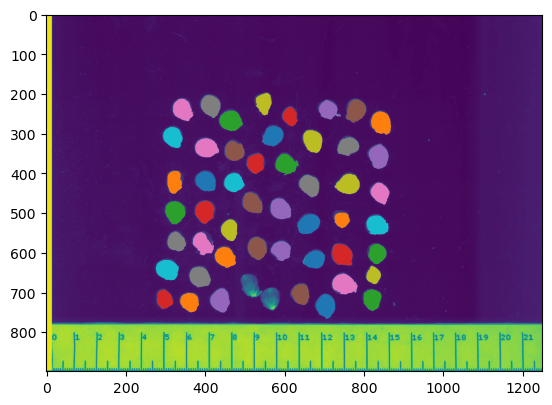

In [95]:
plt.imshow(gray)

for i in range(len(conts)):
    plt.fill(conts[i][:,0],conts[i][:,1])

## Interpolate pseudo-landmarks and measure angles/distances to centroids
-  Set resolution of interpolation
-  Add the first point to the last position of the contour, to close the contour
-  Interpolate
-  Remove last interpolated point (due to overlap)
-  For each point, calculate angle as defined by window, convert to z score
-  For each point, calcualte Euclidean distance to centroid, convert to z score
-  Save results as 4 dimensional array: x coordinate, y coordinate, angle z score, distance z score

In [96]:
res = 201 # how many points to interpolate
win = 60 # window size for detecting angles

z_arr = np.zeros( (len(conts), res-1, 4))

for i in range(len(conts)): # for each contour

    # select current contour
    curr_cont = conts[i]
    
    # close the contour
    closed_arr = np.zeros((len(curr_cont)+1,2))
    closed_arr[:-1] = curr_cont
    closed_arr[-1] = curr_cont[0]
    
    # calculate interpolated contour
    interp = np.column_stack(interpolation(closed_arr[:,0], closed_arr[:,1], res)) 
    
    # remove last point of interpolation
    interp = interp[:-1]
    
    # find angles for each contour point
    angs = detect_pointy_tips(interp, win)
    ang_z = zscore(angs)

    # find distances to centroid
    cent = np.mean(interp, axis=0)

    dists = []
    for j in range(len(interp)):
        dists.append(euclid_dist(cent[0],cent[1], interp[j][0], interp[j][1]))
    dist_z = zscore(dists)
        
    # store contour, angles, dists
    z_arr[i] = np.column_stack((interp, ang_z, dist_z))

Visualize angles around contours

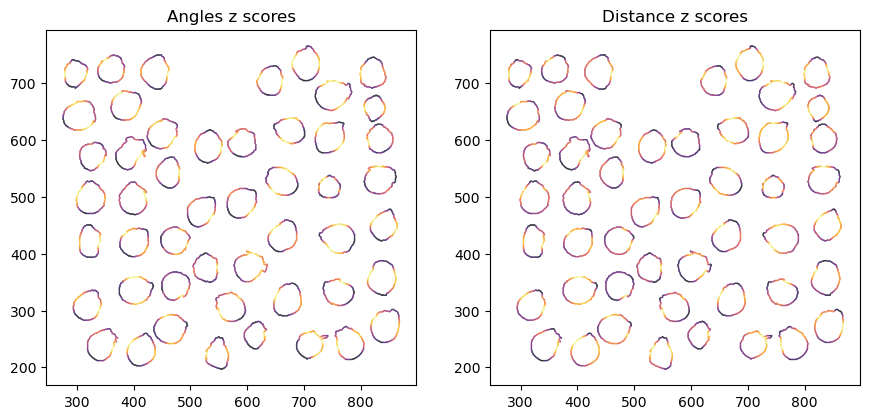

In [97]:
#plt.imshow(image, alpha=0.5)

plt.figure(figsize=(10.5,5))

for i in range(len(z_arr)):
    curr_ker = z_arr[i,:,:]

    plt.subplot(1,2,1)
    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,2], s=1, legend=False, palette="inferno_r")
    plt.gca().set_aspect("equal")
    plt.title("Angles z scores")

    plt.subplot(1,2,2)
    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,3], s=1, legend=False, palette="inferno_r")
    plt.gca().set_aspect("equal")
    plt.title("Distance z scores")



In [98]:
landmarks = np.loadtxt(name + ".txt")

oriented_arr = np.zeros(np.shape(z_arr))

for i in range(len(z_arr)):

    # retrieve the pseudo_landmarks
    pseudos = z_arr[i,:,0:2]
    
    l_inds = [] # store landmark indices
    p_inds = [] # store pseudo-landmark indices
    eds = [] # store euclidean distances
    
    for l in range(len(landmarks)): # for each landmark
        for p in range(len(pseudos)): # for each pseudo-landmark
    
            # calculate eulidean distance
            eds.append(euclid_dist(landmarks[l,0],landmarks[l,1],pseudos[p,0],pseudos[p,1]))
            # store landmark and pseudo-landmark indices
            l_inds.append(l)
            p_inds.append(p)
    
    min_ind = np.argmin(np.array(eds)) # find minimum index
    pseudo_ind = p_inds[min_ind] # find the pseudo_landmark index

    # re-index contour coords and angs and dists
    oriented_arr[i,:,:] = np.concatenate((z_arr[i,pseudo_ind:,:],z_arr[i,:pseudo_ind,:]))



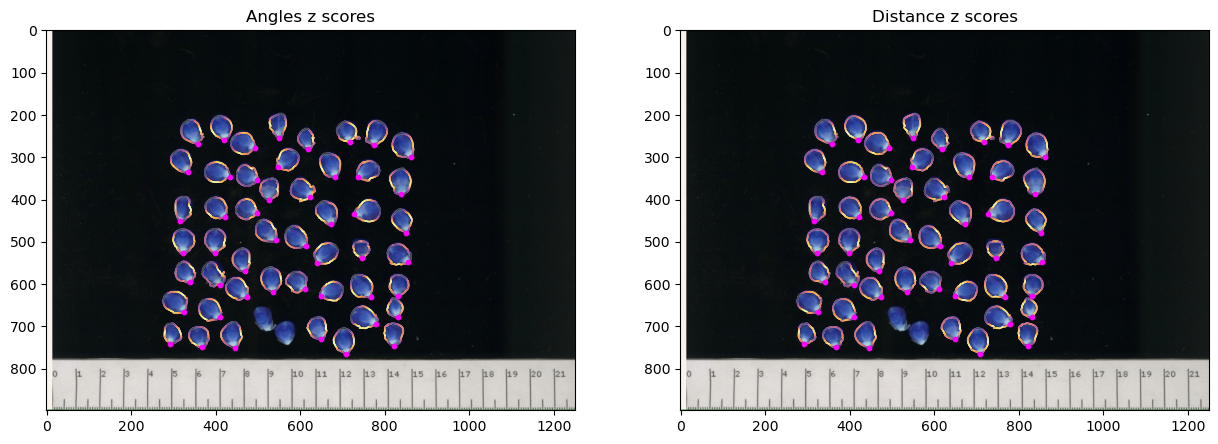

In [99]:
pt_s = 10 # point size
img_a = 0.2 # image alpha

plt.figure(figsize=(15,5))

for i in range(len(z_arr)):
    curr_ker = oriented_arr[i,:,:]

    plt.subplot(1,2,1)
    plt.imshow(image, alpha=img_a)
    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,2], s=1, legend=False, palette="inferno_r")
    plt.scatter(curr_ker[0,0], curr_ker[0,1], c="magenta", s=pt_s)
    plt.gca().set_aspect("equal")
    plt.title("Angles z scores")

    plt.subplot(1,2,2)
    plt.imshow(image, alpha=img_a)
    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,3], s=1, legend=False, palette="inferno_r")
    plt.scatter(curr_ker[0,0], curr_ker[0,1], c="magenta", s=pt_s)
    plt.gca().set_aspect("equal")
    plt.title("Distance z scores")

## Detect landmarks
- Smooth out angles for a given window size
- Smooth out distances for a given window size
- For smoothened angles as a function of pseudo-landmark, there will be two positive peaks (tip/base) and two negative peaks (the sides)
- Set a positive/negative threshold. Find intersections with each threshold. There should be 8 interesections (or, 4 crossings of the zero mark of the angular z score).
- If there are not 8 intersections detected, ignore the current kernel.
- Find the midpoint indices between each of the intersection points, which will be the landmarks (also 8)
- For the two positive angular z score peaks, these will be the tip/base. The tip is defined as having a higher value of (smoothened angle minus smoothened distance value), and the tip as having the lesser value
- Save the eight landmark indices in order: TIP, BORDER, SIDE, BORDER, BASE, BORDER, SIDE, BORDER 

In [8]:
thresh = 0.1 # threshold to call peaks
rwin = 10 # window for smoothing z scores

leaf_list = [] # processed leaves
landmarks = [] # indices of landmarks
smooth_ang_list = [] # list to store smoothened angles
smooth_dist_list = [] # list to store smoothened distances

for i in range(len(z_arr)): # for each kernel

    a = z_arr[i,:,2] # get current kernel angles
    smooth_ang = [] # calculate smoothened z scores angles
    for j in range(len(a)):
        rolled = np.roll(a, -j)
        roll_window = rolled[:rwin]
        smooth_ang.append(np.mean(roll_window))
    
    d = z_arr[i,:,3] # get current kernel distances
    smooth_dist = [] # calculate smoothened z scores distances
    for k in range(len(d)):
        rolled = np.roll(d, -k)
        roll_window = rolled[:rwin]
        smooth_dist.append(np.mean(roll_window))
    
    # Find intersection indices with thresholds
    positive_intersection = np.where(np.diff(np.sign(np.array(smooth_ang) - thresh)))[0]
    negative_intersection = np.where(np.diff(np.sign(np.array(smooth_ang) + thresh)))[0]
    inter = np.concatenate((negative_intersection, positive_intersection))
    inter.sort()

    # if 8 intersections are not detected, ignore
    if len(inter)!=8:
        continue
    
    # create an array of the indices
    ind_arr = np.arange(0,res-1)
    
    # find landmarks as midpoint values
    landmark_indices = [] 
    for l in range(8):
        indices = foo(ind_arr, inter[l%8], inter[(l+1)%8]+1)
        #index_list.append(inter[l%8])
        landmark_indices.append(indices[len(indices)//2])
    
    # find smooth_ang and smooth_dist values for indices
    smooth_ang_vals = [smooth_ang[i] for i in landmark_indices]
    smooth_dist_vals = [smooth_dist[i] for i in landmark_indices]
    
    # sort smooth_ang values (negative to positive)
    sorted_indices = np.argsort(smooth_ang_vals)
    
    # find the tip and base index (the index of landmark_indices that is the tip or base)
    if (smooth_ang_vals[sorted_indices[-1]]-smooth_dist_vals[sorted_indices[-1]]) > (smooth_ang_vals[sorted_indices[-2]]-smooth_dist_vals[sorted_indices[-2]]):
        tip_index = sorted_indices[-1]
        base_index = sorted_indices[-2]
    else:
        tip_index = sorted_indices[-2]
        base_index = sorted_indices[-1]
    
    # reindex landmarks starting at tip
    # TIP, BORDER, SIDE, BORDER, BASE, BORDER, SIDE, BORDER
    indices_from_tip = np.concatenate(  (landmark_indices[tip_index:],landmark_indices[:tip_index] ) )

    leaf_list.append(i)
    landmarks.append(indices_from_tip)
    smooth_ang_list.append(smooth_ang)
    smooth_dist_list.append(smooth_dist)


## Visualize placed landmarks

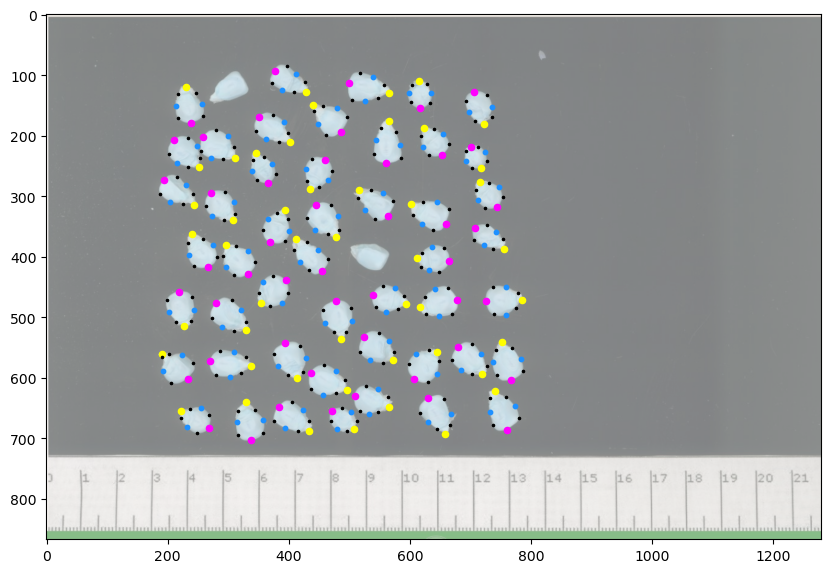

In [9]:
pt_size=5

plt.figure(figsize=(10,10))
plt.imshow(image, alpha=0.5)

#for i in range(len(z_arr)):
#    curr_ker = z_arr[i,:,:]

#    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,2], s=1, legend=False, palette="inferno_r")
#    plt.gca().set_aspect("equal")

for j in range(len(leaf_list)):

    curr_leaf = z_arr[leaf_list[j]]
    curr_landmarks = landmarks[j]
    
    tip_index = int(curr_landmarks[0])
    base_index = int(curr_landmarks[4])
    side_index1 = int(curr_landmarks[2])
    side_index2 = int(curr_landmarks[6])
    border_index1 = int(curr_landmarks[1])
    border_index2 = int(curr_landmarks[3])
    border_index3 = int(curr_landmarks[5])
    border_index4 = int(curr_landmarks[7])

    plt.scatter(curr_leaf[tip_index][0], curr_leaf[tip_index][1], c="magenta", s=pt_size*4)
    plt.scatter(curr_leaf[base_index][0], curr_leaf[base_index][1], c="yellow", s=pt_size*4)
    plt.scatter(curr_leaf[side_index1][0], curr_leaf[side_index1][1], c="dodgerblue", s=pt_size*2)
    plt.scatter(curr_leaf[side_index2][0], curr_leaf[side_index2][1], c="dodgerblue", s=pt_size*2)

    plt.scatter(curr_leaf[border_index1][0], curr_leaf[border_index1][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index2][0], curr_leaf[border_index2][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index3][0], curr_leaf[border_index3][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index4][0], curr_leaf[border_index4][1], c="k", s=pt_size/2)


## Visualize angular, angular-distance values
Evaluating angle and angle-distance across the contour might be a better way to orient and assign landmark positions

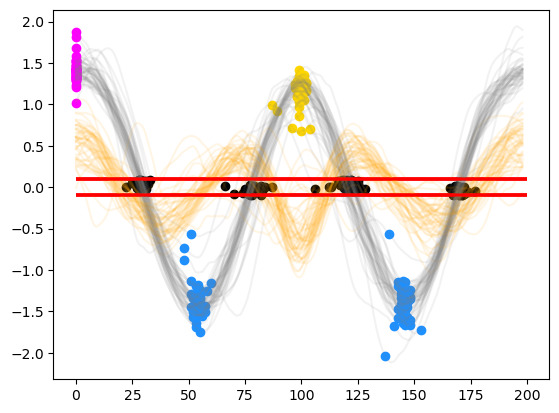

In [10]:
for i in range(len(leaf_list)):

    new_ind = int(landmarks[i][0]) # new index to reindex data to, starting at tip
    
    coords = z_arr[leaf_list[i],:,:2] # get current leaf coordinates
    angs = smooth_ang_list[i] # get current leaf angles
    dists = smooth_dist_list[i] # get current leaf distances
    angs_dists = np.array(angs)-np.array(dists) # calculate angle-distance values
    x_vals = np.arange(0,len(angs),1) # indices for plotting
    new_lands = (landmarks[i]-new_ind) % len(angs) # landmarks reindexed with the tip at zero
    new_lands = new_lands.astype(int)
    
    new_angs = np.concatenate((angs[new_ind:],angs[:new_ind]))
    new_ang_dists = np.concatenate((angs_dists[new_ind:],angs_dists[:new_ind]))
    
    plt.plot(x_vals, new_angs, c="gray", alpha=0.1)
    plt.plot(x_vals, new_ang_dists, c="orange", alpha=0.1)
    
    # TIP, BORDER, SIDE, BORDER, BASE, BORDER, SIDE, BORDER
    plt.scatter(new_lands[0], new_angs[new_lands[0]], c="magenta")
    plt.scatter(new_lands[1], new_angs[new_lands[1]], c="k")
    plt.scatter(new_lands[2], new_angs[new_lands[2]], c="dodgerblue")
    plt.scatter(new_lands[3], new_angs[new_lands[3]], c="k")
    plt.scatter(new_lands[4], new_angs[new_lands[4]], c="gold")
    plt.scatter(new_lands[5], new_angs[new_lands[5]], c="k")
    plt.scatter(new_lands[6], new_angs[new_lands[6]], c="dodgerblue")
    plt.scatter(new_lands[7], new_angs[new_lands[7]], c="k")
    
    plt.hlines(thresh, 0, 200, "r")
    plt.hlines(-thresh, 0, 200, "r")